In [1]:
import pyocr
import cv2
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

In [2]:
def plot_img(img, is_gray=False, figsize=(20, 25)):
    plt.figure(figsize=figsize)
    if is_gray:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.show()

def bgr2rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def binarize(img_rgb, th= 255 // 2):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, img_bin = cv2.threshold(img_gray, th, 255, cv2.THRESH_BINARY)
    return img_bin

def binarize_otsu(img_rgb):
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    th, img_bin = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img_bin


def erode(img_bin, kernel_size=5, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.erode(img_bin, kernel, iterations)

def find_contours(img):
    contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# レシピ読み上げさん

### 読み込んだ画像の前処理
とりあえず自然画像じゃなくて，Kindleのレシピ本のスクリーンショットを用いる．

1. RGB画像をグレースケールに変換し，大津の二値化によりバイナリ画像に変換
   - クラス間分散が最大となるように閾値を選択
2. 輪郭→矩形検出を行い，ある程度の大きさを持った矩形を画像中にある写真とみなして白塗り
3. 写真部分を白塗りしたバイナリ画像に収縮処理（黒の領域を拡大）を行い，テキストの文字を太くし，文字間をつなげる．
4. 収縮処理を行ったバイナリ画像に対して再び輪郭→矩形検出を行うと，つながったテキストが矩形として検出できる．
5. 検出したテキストボックスにOCRを行い，先頭の文字が数字のもののみを「手順」として取り出す．
   - 数字が〇で囲われていると，認識精度が落ちるので，〇を検知して白塗り

### 今後行うこと
- 音声との融合
  - 各手順をオートマトンのように状態として管理する．
  - 「次」： 現在の手順の次の手順を読み上げ，次の手順へと状態を遷移する．
  - 「前」： 現在の手順のひとつ前の手順を読み上げ，状態をそのまま．
  - 「もう一回」： 現在の手順を再読し，状態はそのまま．
  - 「手順２」： 指定された手順を読み上げ，状態はそのまま．

### 将来
- 自然画像で行う
  - ホモグラフィ変換により撮影したレシピが長方形になるように修正

### 提案
- タイトルを取り出すようにする

================== 入力画像 ==================


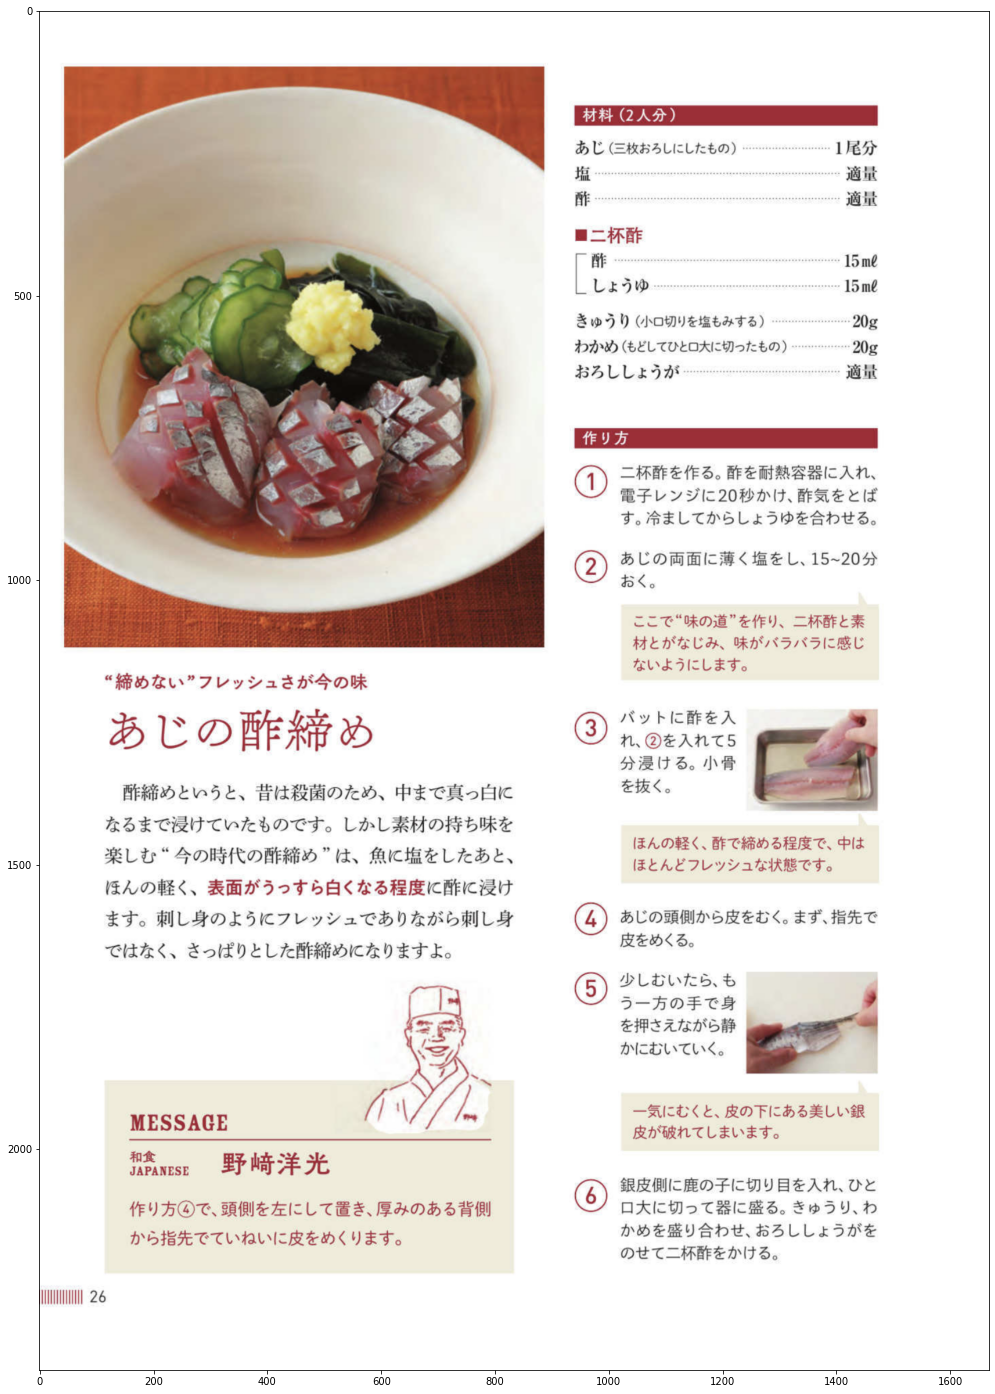



================== ステップ1. 大津の二値化 ==================


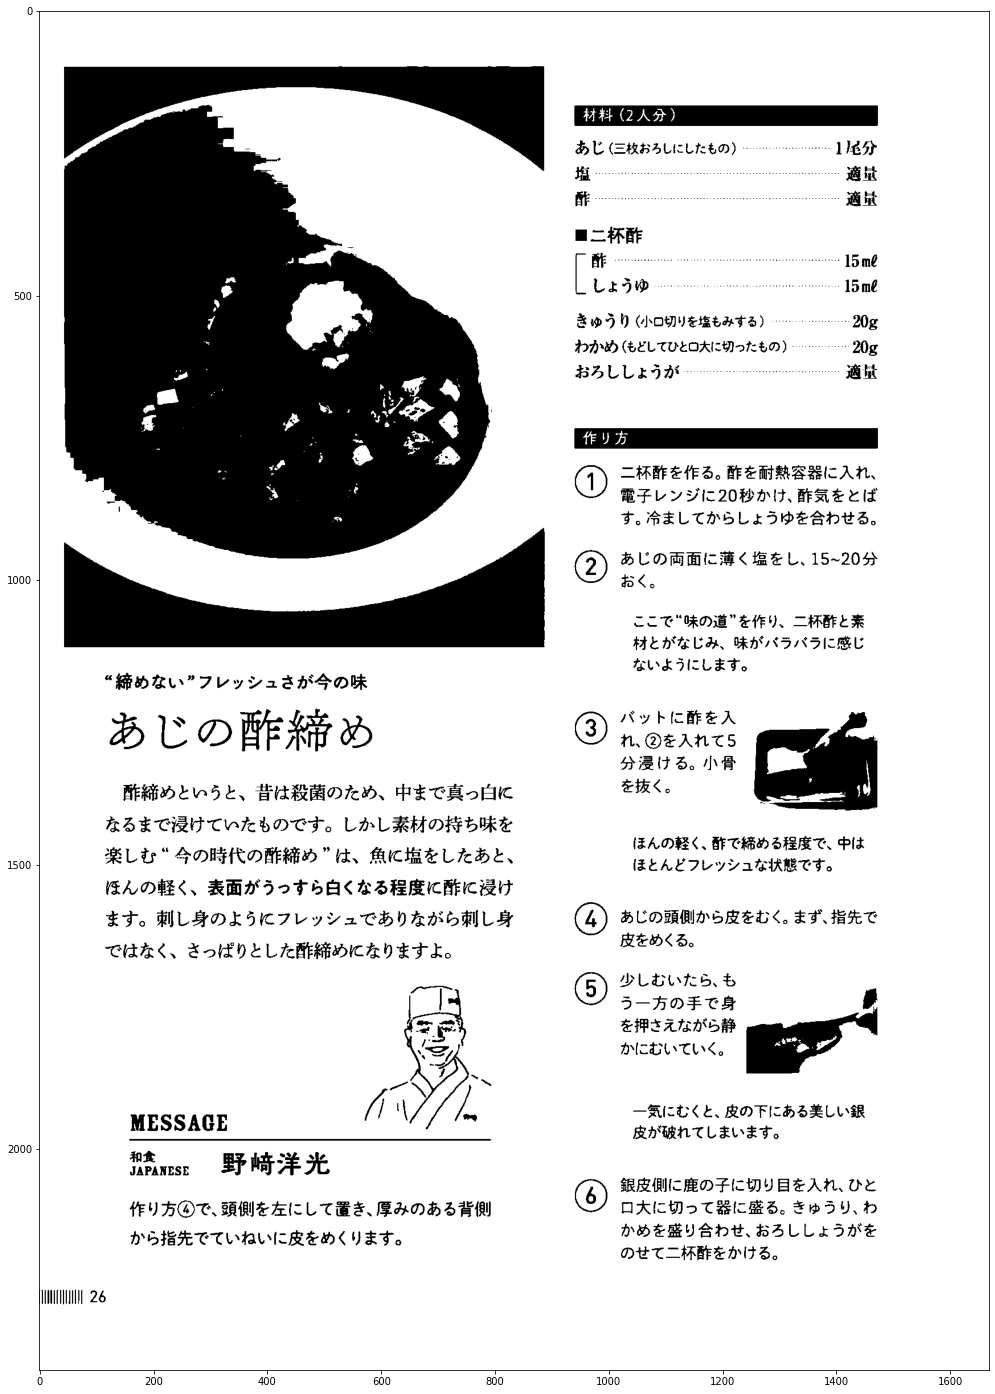



================== ステップ2. 画像中の写真を白塗り ==================


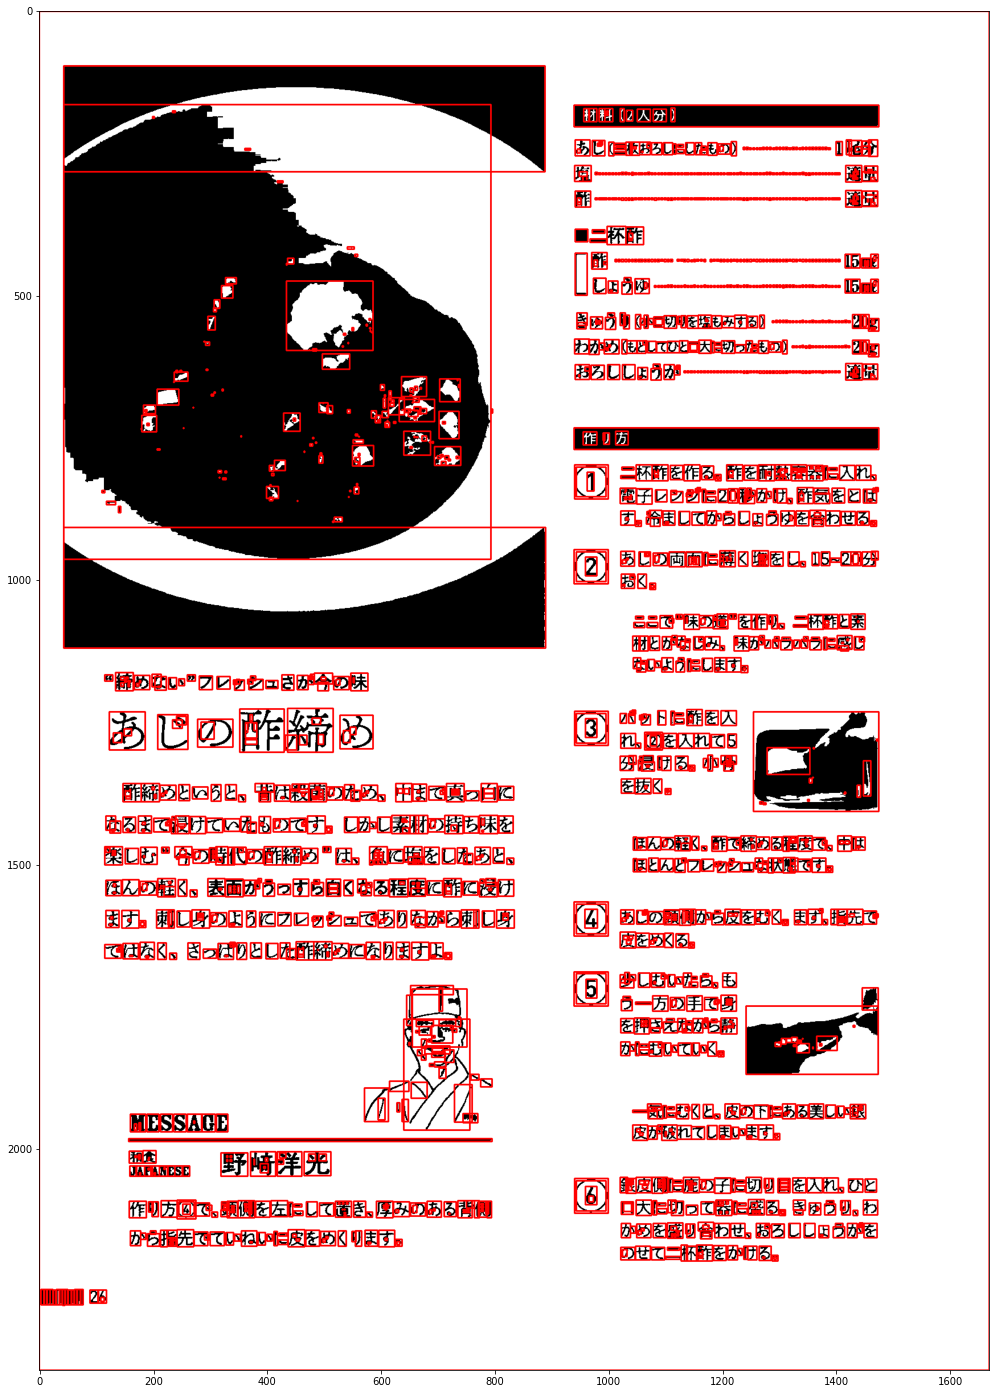

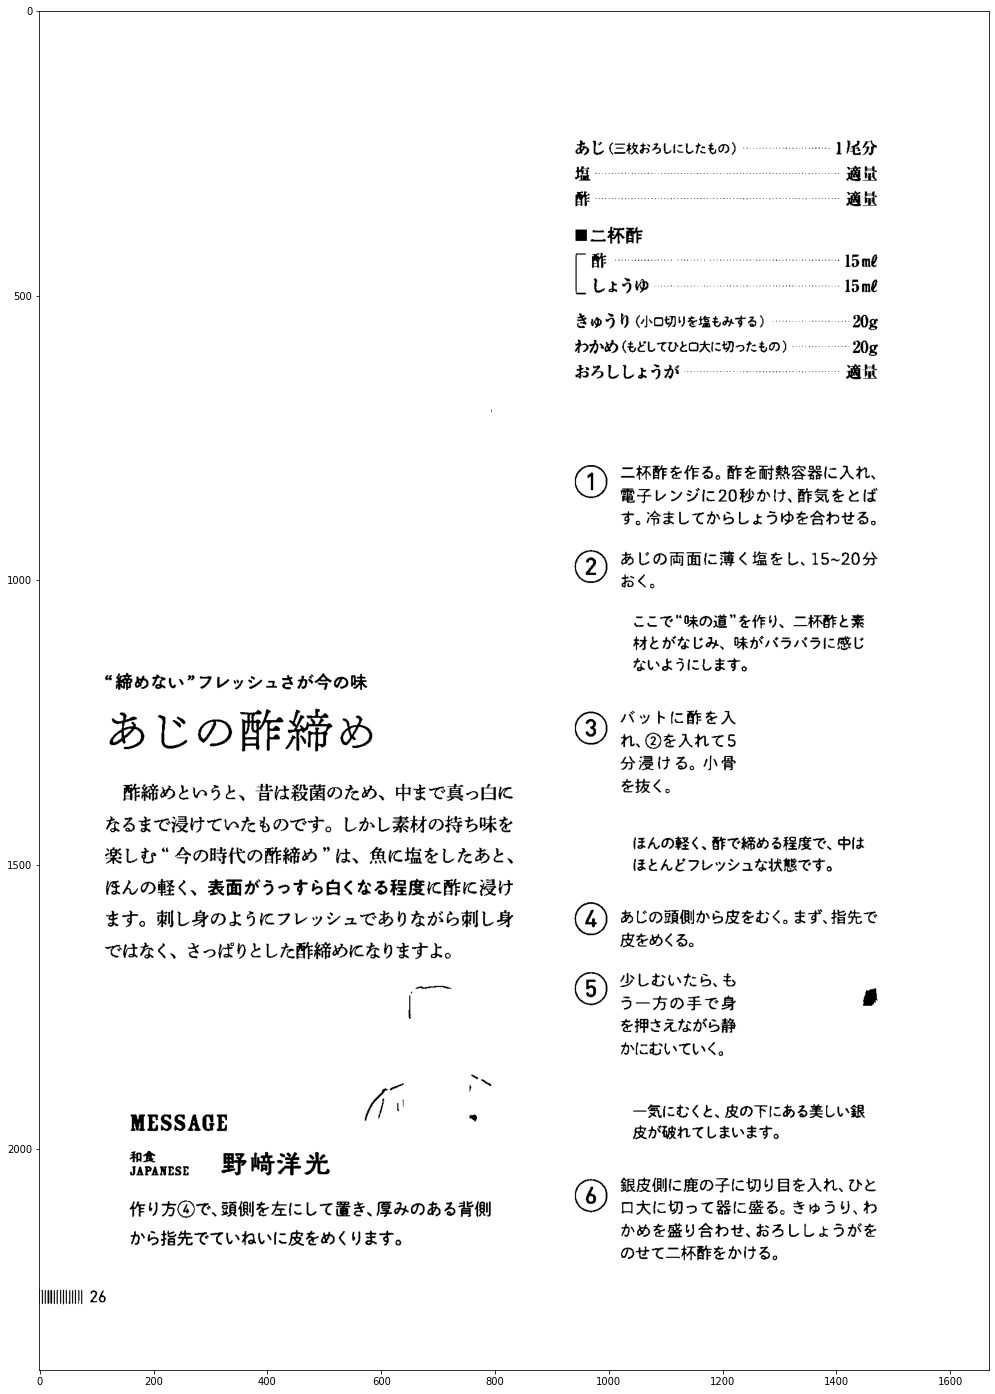



================== ステップ3. 収縮処理によりテキスト同士をつなげる ==================


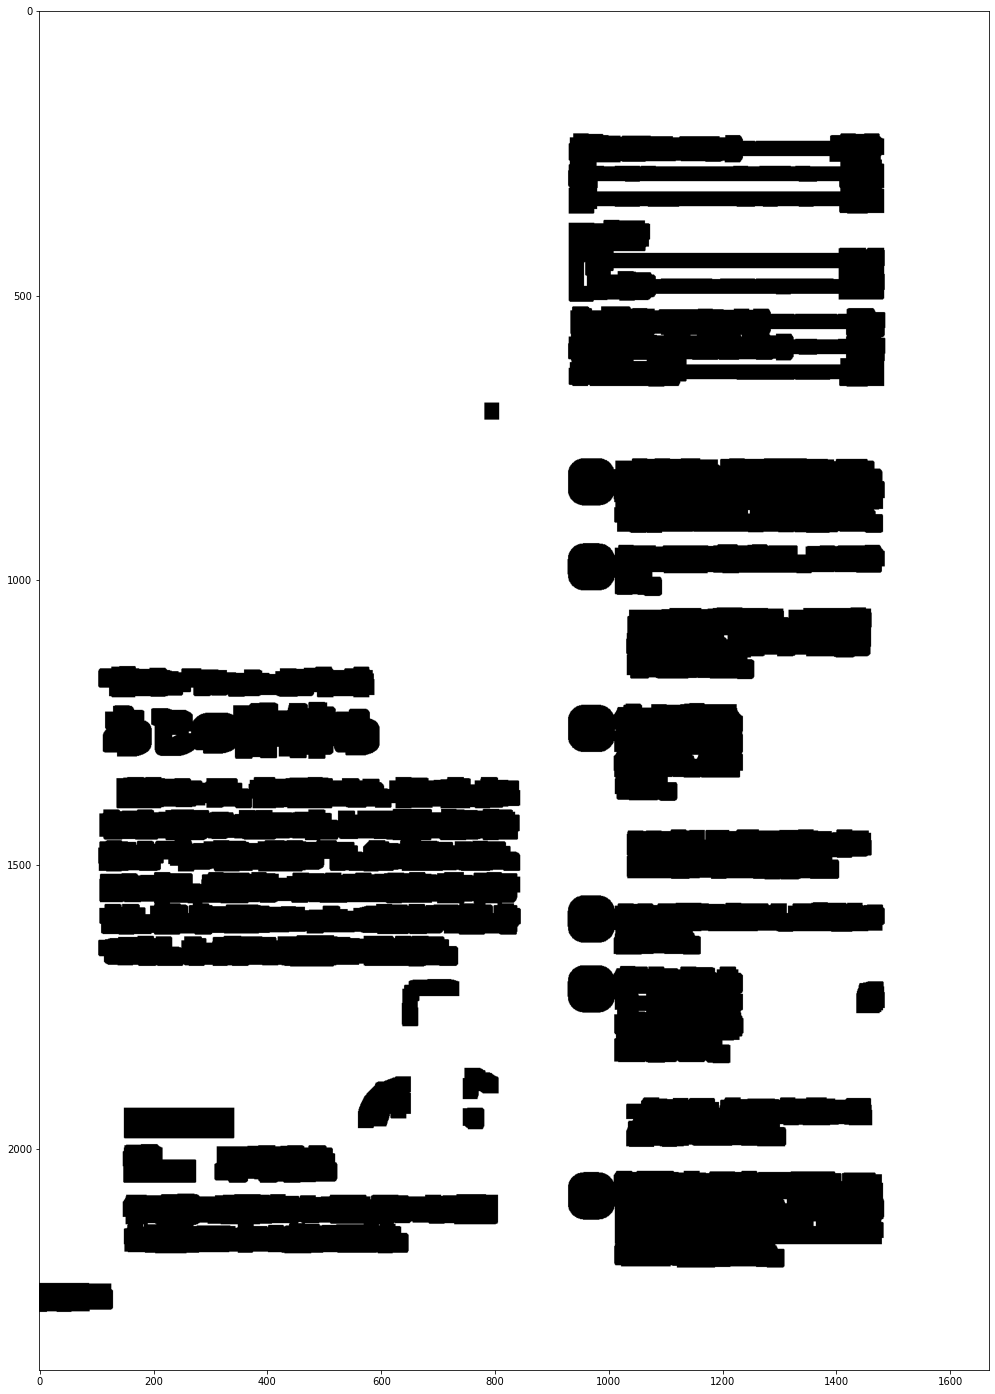



================== ステップ4. テキストボックスを検出 ==================


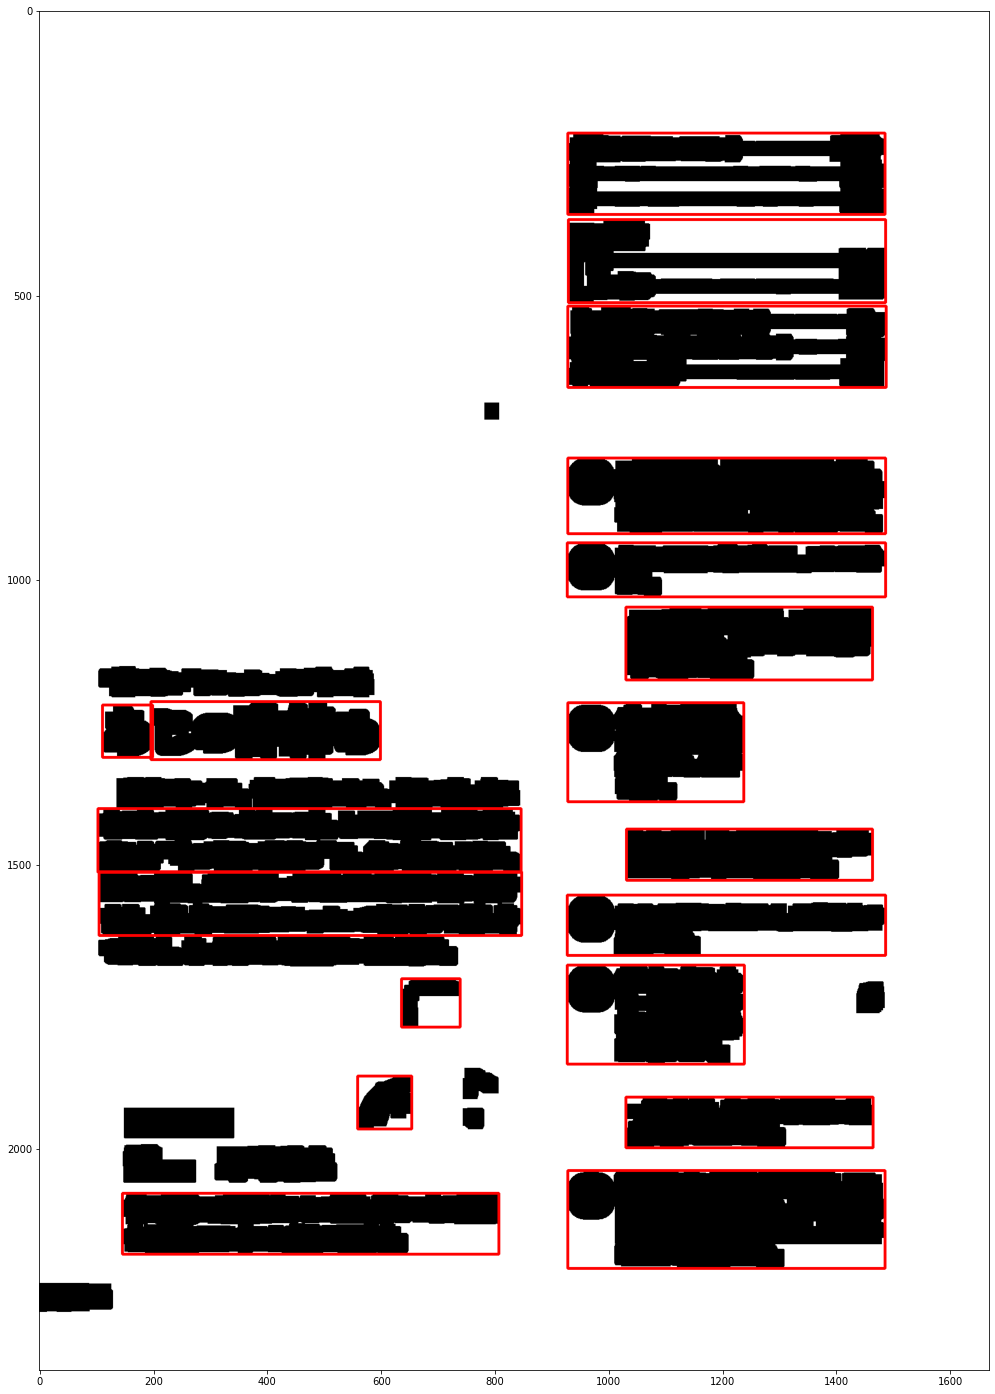

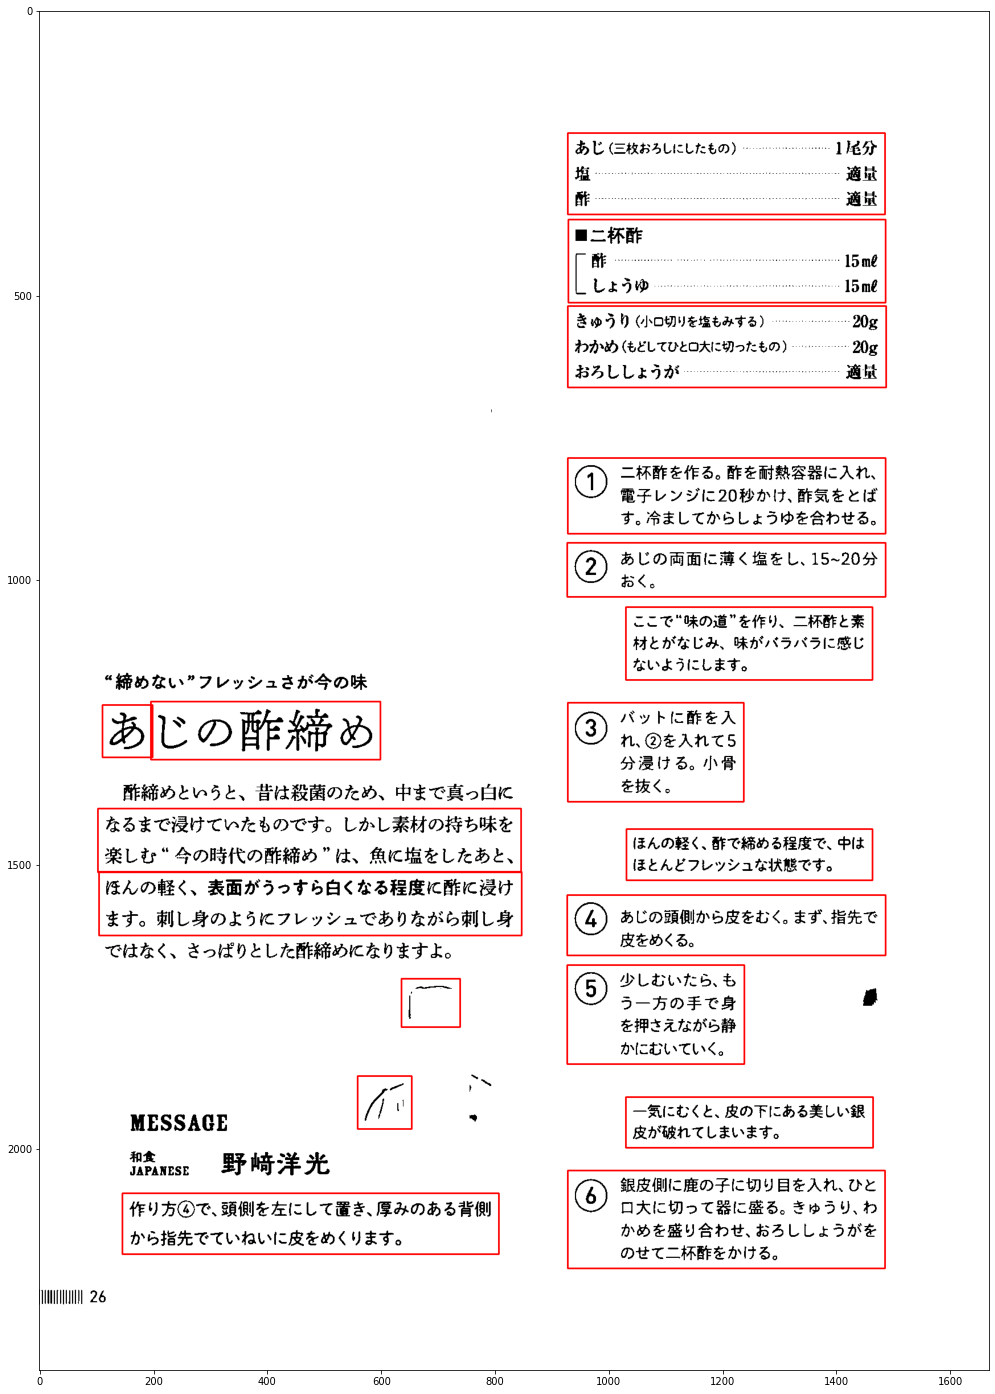



================== ステップ5. 〇を白塗りし，テキストボックスに対してOCR ==================


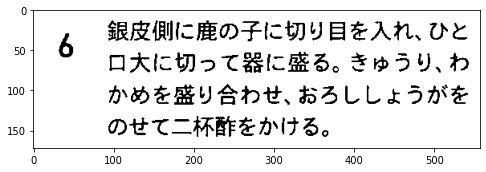

6銀皮側に鹿の子に切り目を入れ、ひと口大に切って器に盛る。きゅうり、わかめを盛り合わせ、おろししょうがをのせて二杯酢をかける。


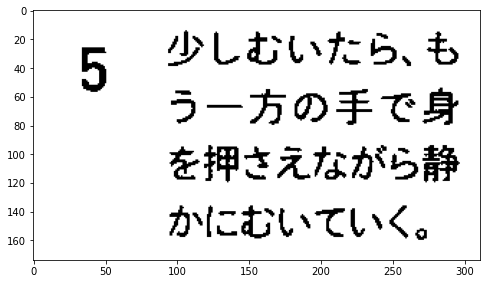

5少しむいたら、もう一方の手で身を押さえながら静かにむいていく。


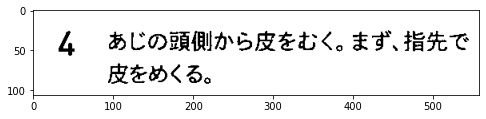

4あじの頭側から皮をむく。まず、指先で皮をめくる。


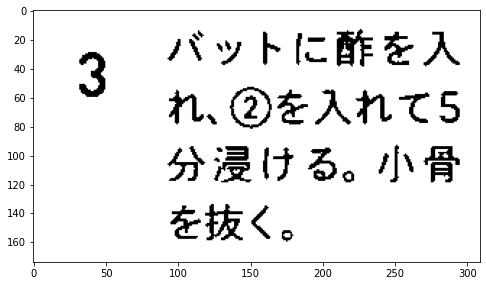

3バットに酢を入れ、②を入れて5分浸ける。小骨を抜く。


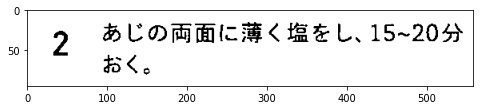

2あじの両面に薄く塩をし、15-~20分おく。


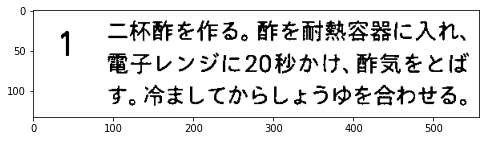

1ニニ杯酢を作る。酢を耐熱容器に入れ、電子レンジに20秒かけ、酢気をとばす。冷ましてからしょうゆを合わせる。


In [18]:
# imgpath = Path("src/recipes/recipe2.png")w
imgpath = Path("src/recipes/recipe6.png")
# imgpath = Path("src/recipes/recipe4.png")
# imgpath = Path("src/recipes/recipe8.png")
img_bgr = cv2.imread(str(imgpath))
img = bgr2rgb(img_bgr)

print("================== 入力画像 ==================")
plot_img(img)

img_h, img_w, _ = img.shape
img_bin = binarize_otsu(img)
print("\n\n================== ステップ1. 大津の二値化 ==================")
plot_img(img_bin, is_gray=True)

contours = find_contours(img_bin)

# 画像全面を覆うほど大きくなく，ある程度の大きさを持つ矩形は，画像中の写真であるとして白塗りする
img_bin_cp = img_bin.copy()
img_bin_cp = cv2.cvtColor(img_bin_cp, cv2.COLOR_GRAY2BGR)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(img_bin_cp,(x, y), (x + w, y + h), (255, 0, 0, 255), 2)
    if (w < img_w * 0.9 and h < img_h * 0.9) and (w > img_w * 0.05 or h > img_h * 0.05):
        img_bin[y : y + h, x : x + w] = 255
print("\n\n================== ステップ2. 画像中の写真を白塗り ==================")
plot_img(img_bin_cp, is_gray=True)
plot_img(img_bin, is_gray=True)

eroded_img = erode(img_bin, 26, 1)
print("\n\n================== ステップ3. 収縮処理によりテキスト同士をつなげる ==================")
plot_img(eroded_img, is_gray=True)

contours = find_contours(eroded_img)

procedure_imgs = []

img_bin_cp = cv2.cvtColor(img_bin.copy(), cv2.COLOR_GRAY2BGR)
eroded_cp = cv2.cvtColor(eroded_img.copy(), cv2.COLOR_GRAY2BGR)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w > img_w * 0.03 and h > img_h * 0.03 and h * w < img_w * img_h * 0.1:
        cv2.rectangle(img_bin_cp,(x, y), (x + w, y + h), (255, 0, 0, 255), 2)
        cv2.rectangle(eroded_cp,(x, y), (x + w, y + h), (255, 0, 0, 255), 3)
        procedure_imgs.append(img[y : y + h, x : x + w, :])
print("\n\n================== ステップ4. テキストボックスを検出 ==================")
plot_img(eroded_cp)
plot_img(img_bin_cp)

tool = pyocr.get_available_tools()[0]
builder = pyocr.builders.TextBuilder(tesseract_layout=6)

print("\n\n================== ステップ5. 〇を白塗りし，テキストボックスに対してOCR ==================")
procedures = {}

for procedure_img in procedure_imgs:
    procedure_bin = binarize(procedure_img, th=180)
    # procedure_bin = binarize_otsu(procedure_img)
    
    # 上半分・下半分・左半分・右半分で黒いピクセルが80%以上を占めるとき，それは主に画像である不要な領域なので排除する
    is_image_box = False
    h, w, _ = procedure_img.shape 
    for left, right, up, bottom in [[0, w, 0, h // 2], [0, w, h // 2, h], [0, w // 2, 0, h], [w // 2, w, 0, h]]:
        if cv2.countNonZero(procedure_bin[up : bottom, left : right]) < h * w * 0.2:
            is_image_box = True

    if not is_image_box:
        # dp:float  投票器の解像度．大きいほど検出基準が緩くなる
        # minDist:float  検出される円同士が最低限離れている距離
        # param1:float  内部で行われているCanny法によるエッジ検出の上限値
        # param2:float  円の中心を検出する際の閾値．低い値にすると誤検出が多くなる 
        # circles = cv2.HoughCircles(procedure_bin, cv2.HOUGH_GRADIENT, dp=0.1, minDist=100, param1=100, param2=30, minRadius=20, maxRadius=50)
        circles = cv2.HoughCircles(
            procedure_bin, 
            cv2.HOUGH_GRADIENT, 
            dp=0.1, 
            minDist=min(img_h, img_w) // 20, 
            param1=100, 
            param2=30, 
            minRadius=min(img_h, img_w) // 100, 
            maxRadius=min(img_h, img_w) // 50
        )
        if circles is not None:
            for circle in circles[0]:
                procedure_bin = cv2.circle(procedure_bin, (int(circle[0]), int(circle[1])), int(circle[2]), 255, min(img_h, img_w) // 150)

        text = tool.image_to_string(Image.fromarray(procedure_bin), lang="jpn", builder=builder)
        text = text.replace("\n", "").replace(" ", "")

        nums = [str(i) for i in range(10)]
        if len(text) > 5:
            if text[0] in nums:
                procedures[int(text[0])] = text[1:]
                plot_img(procedure_bin, is_gray=True, figsize=(8, 5))
                cv2.imwrite(f"./proc_imgs/proc_{text[0]}.png", procedure_bin)
                print(text)
            elif text[1] in nums:
                # 先頭の一文字目に余計なものが入っている場合のみ許容する
                # HACK: 正規表現を用いて実装可能
                procedures[int(text[1])] = text[2:]
                plot_img(procedure_bin, is_gray=True, figsize=(8, 5))
                cv2.imwrite(f"./proc_imgs/proc_{text[1]}.png", procedure_bin)
                print(text[1:])

In [16]:
%pwd

'c:\\Users\\genki\\workspace\\recipe_speaker'